# Making Synthesis Damage

## Import Library

In [1]:
import os, glob, cv2, random
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

## Mengambil Data Sample

In [ ]:
train_path = 'train-bin'
test_path = 'test-bin'

In [3]:
# fungsi untuk load data
def process_image(img_path):
	img = cv2.imread(img_path)
	if img is None:
		return None
	
	# Resize image
	img = cv2.resize(img, (256, 256))

	return img

def load_data(folder_path, max_samples):
	images = []
	subfolders = ['jajusalatin', 'kramayana', 'samkok', 'sramayana']
	samples_per_folder = max_samples // len(subfolders)

	for subfolder in subfolders:
		subfolder_path = os.path.join(folder_path, subfolder)
		files = sorted(glob.glob(os.path.join(subfolder_path, '*.png')) + glob.glob(os.path.join(subfolder_path, '*.bmp')))[:samples_per_folder]

		# Gunakan tqdm untuk menampilkan progress bar
		for img_path in tqdm(files, desc=f"Loading {subfolder}", unit="image"):
			img = process_image(img_path)
			if img is not None :
				images.append(img)

	return np.array(images)

# Load data
print("Loading data train...")
x_train = load_data(train_path, max_samples=400)
print()
print("Loading data test...")
x_test = load_data(test_path, max_samples=100)

Loading data train...


Loading sramayana: 100%|██████████| 100/100 [00:02<00:00, 46.54image/s]



Loading data test...


Loading sramayana: 100%|██████████| 25/25 [00:00<00:00, 65.26image/s]


In [4]:
print(f"x_train shape => {x_train.shape} & x_test shape => {x_test.shape}")
print(f"x_train dtype => {x_train.dtype} & x_test dtype => {x_test.dtype}")

print()
# Cek normalisasi citra
print(f"Nilai pixel => min : {x_train.min()} & max => {x_train.max()}")

x_train shape => (400, 256, 256, 3) & x_test shape => (100, 256, 256, 3)
x_train dtype => uint8 & x_test dtype => uint8

Nilai pixel => min : 0 & max => 255


## Suffle Data Sample

In [5]:
# Suffle Data Sample
[np.random.shuffle(x_train) for _ in range(3)]
[np.random.shuffle(x_test) for _ in range(3)]

[None, None, None]

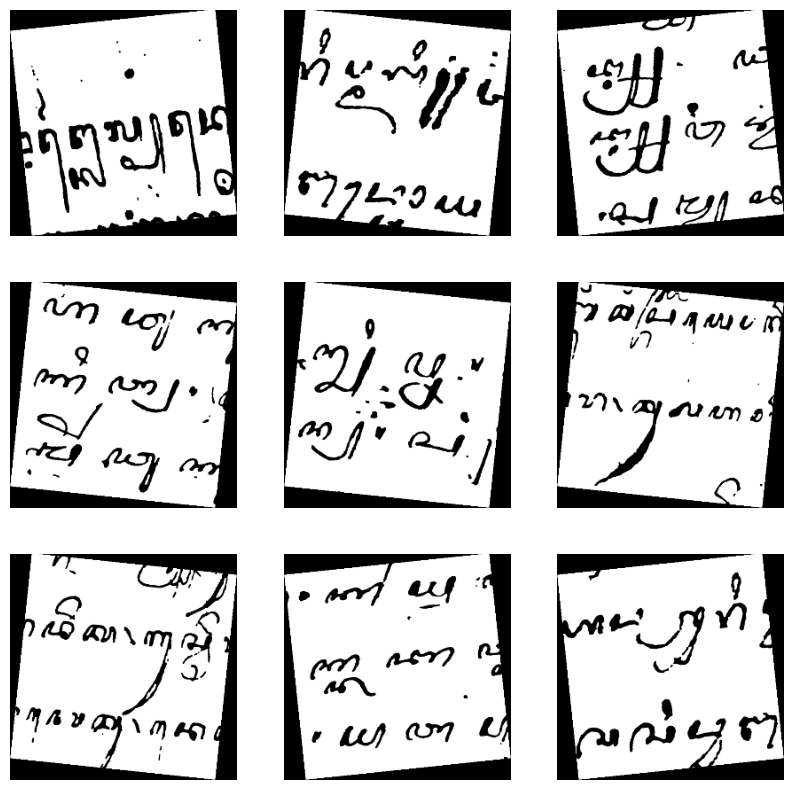

In [6]:
# Visualisasi data
plt.figure(figsize=(10, 10))
for i in range(9):
	plt.subplot(3, 3, i+1)
	plt.imshow(x_train[i])
	plt.axis('off')
plt.show()


## Kerusakan Buatan

In [7]:
# Fungsi untuk menambahkan efek BERLUBANG (1 lubang besar)
def add_hole_damage(image):
	damaged = image.copy()
	h, w = damaged.shape[:2]

	# Tentukan titik dan radius lubang
	x, y = random.randint(50, w-50), random.randint(50, h-50)
	radius = random.randint(15, 30)

	# Warna abu-abu untuk lubang
	grey_color = (128, 128, 128)

	# Buat lubang dengan warna abu-abu
	cv2.circle(damaged, (x, y), radius, grey_color, -1)
	return damaged

# Fungsi untuk menambahkan efek Tinta Tembus
def add_ink_bleed(image):
	damaged = image.copy()
	h, w = damaged.shape[:2]
	x_offset = random.randint(10, 20)
	y_offset = random.randint(10, 20)
	mask = np.zeros_like(damaged)

	# Pindahkan aksara agar terlihat tembus
	mask[y_offset:h, x_offset:w] = damaged[0:h-y_offset, 0:w-x_offset]

	# Gabungkan dengan gambar asli (dengan opacity rendah)
	damaged = cv2.addWeighted(damaged, 0.8, mask, 0.2, 0)
	return damaged

# Fungsi untuk menambahkan efek Bercak
def add_stain_damage(image):
	damaged = image.copy()
	h, w = damaged.shape[:2]

	for _ in range(random.randint(1, 3)):  # Tambahkan 1-3 bercak
		x, y = random.randint(20, w-50), random.randint(20, h-50)
		size = random.randint(20, 50)

		# Tentukan warna bercak abu-abu acak
		gray_value = random.randint(100, 200)  # Nilai 100-200 untuk abu-abu

		# Buat bercak berwarna abu-abu (sama untuk R, G, B)
		stain = np.full((size, size, 3), gray_value, dtype=np.uint8)

		# Tambahkan Gaussian Blur agar bercak tampak lebih alami
		stain = cv2.GaussianBlur(stain, (5, 5), 0)

		# Pastikan ukuran bercak sesuai dengan area gambar
		if damaged[y:y+size, x:x+size].shape == stain.shape:
			# Gabungkan bercak dengan gambar asli
			blended = cv2.addWeighted(damaged[y:y+size, x:x+size], 0.3, stain, 0.7, 0)
			damaged[y:y+size, x:x+size] = blended

	return damaged

# Fungsi untuk menambahkan efek TEKS HILANG (Blurring area tertentu)
def add_missing_text(image):
	damaged = image.copy()
	h, w, = damaged.shape[:2]

	for _ in range(random.randint(2, 4)):  # Hilangkan 2-4 area teks
		x, y = random.randint(20, w-160), random.randint(20, h-60)  # Area blur diperbesar
		width, height = random.randint(80, 160), random.randint(30, 60)  # Ukuran blur lebih besar

		blur_region = damaged[y:y+height, x:x+width]

		blur_region = cv2.GaussianBlur(blur_region, (19, 19), 0)  # Blur lebih intens, kernel size diganti menjadi (19, 19)

		damaged[y:y+height, x:x+width] = blur_region

	return damaged

## Data dipisah menjadi 4 

### Train

In [8]:
split_samples = len(x_train) // 4

train_labels = []

# Bagi dataset train menjadi 4 bagian sesuai jenis kerusakan

# Hole damage
train_hole = np.array([add_hole_damage(img) for img in tqdm(x_train[:split_samples], desc="Adding hole damage")])
train_labels.extend(['hole'] * split_samples)

# Ink bleed
train_bleed = np.array([add_ink_bleed(img) for img in tqdm(x_train[split_samples:split_samples*2], desc="Adding ink bleed")])
train_labels.extend(['bleed'] * split_samples)

# Stain damage
train_stain = np.array([add_stain_damage(img) for img in tqdm(x_train[split_samples*2:split_samples*3], desc="Adding stain")])
train_labels.extend(['stain'] * split_samples)

# Missing text
train_missing = np.array([add_missing_text(img) for img in tqdm(x_train[split_samples*3:split_samples*4], desc="Adding missing text")])
train_labels.extend(['missing'] * split_samples)

Adding missing text: 100%|██████████| 100/100 [00:00<00:00, 579.02it/s]


### Test

In [9]:
split_samples = len(x_test) // 4

test_labels = []

# Bagi dataset test menjadi 4 bagian sesuai jenis kerusakan

# Hole damage
test_hole = np.array([add_hole_damage(img) for img in tqdm(x_test[:split_samples], desc="Adding hole damage")])
test_labels.extend(['hole'] * split_samples)

# Ink bleed
test_bleed = np.array([add_ink_bleed(img) for img in tqdm(x_test[split_samples:split_samples*2], desc="Adding ink bleed")])
test_labels.extend(['bleed'] * split_samples)

# Stain damage
test_stain = np.array([add_stain_damage(img) for img in tqdm(x_test[split_samples*2:split_samples*3], desc="Adding stain")])
test_labels.extend(['stain'] * split_samples)

# Missing text
test_missing = np.array([add_missing_text(img) for img in tqdm(x_test[split_samples*3:split_samples*4], desc="Adding missing text")])
test_labels.extend(['missing'] * split_samples)

Adding missing text: 100%|██████████| 25/25 [00:00<00:00, 410.11it/s]


## Visualisasikan

In [10]:
def visualize_damaged_images(data_prefix):
	fig, axes = plt.subplots(1, 4, figsize=(15, 5))

	axes[0].imshow(eval(f'{data_prefix}_hole')[0])
	axes[0].set_title("Berlubang")
	axes[0].axis('off')

	axes[1].imshow(eval(f'{data_prefix}_bleed')[0])
	axes[1].set_title("Tinta Tembus")
	axes[1].axis('off')

	axes[2].imshow(eval(f'{data_prefix}_stain')[0])
	axes[2].set_title("Bercak")
	axes[2].axis('off')

	axes[3].imshow(eval(f'{data_prefix}_missing')[0])
	axes[3].set_title("Teks Hilang")
	axes[3].axis('off')

	plt.show()

### Train

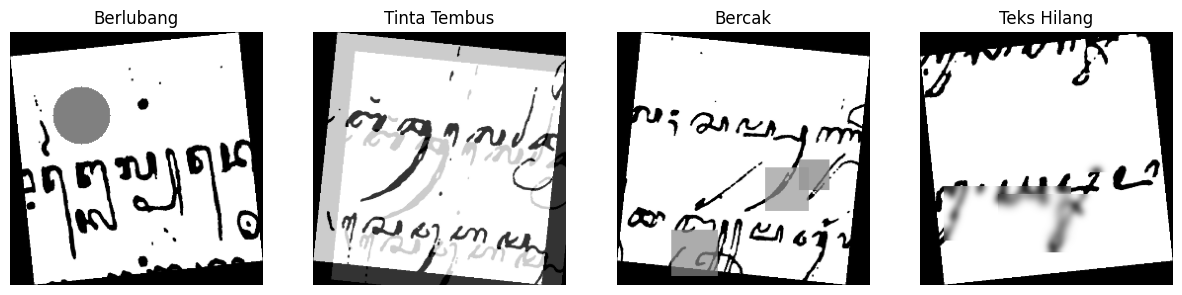

In [11]:
visualize_damaged_images('train')

### Test

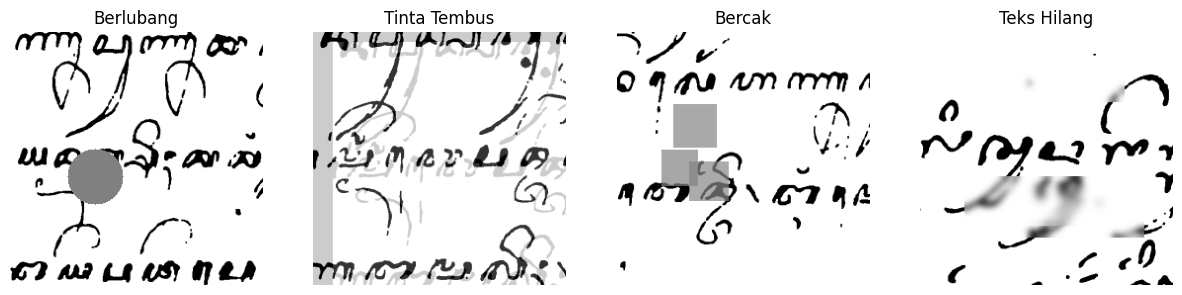

In [12]:
visualize_damaged_images('test')

## Data dikumpulkan jadi 1 

### Train

In [13]:
train_data = np.concatenate([train_hole, train_bleed, train_stain, train_missing], axis=0)
train_labels = np.array(train_labels)

# Cek shape dan dtype
print(f"train_data shape => {train_data.shape}")
print(f"train_data dtype => {train_data.dtype}")

print()
# Cek normalisasi citra
print(f"Nilai pixel => min : {train_data.min()} & max => {train_data.max()}")

train_data shape => (400, 256, 256, 3)
train_data dtype => uint8

Nilai pixel => min : 0 & max => 255


### Test

In [14]:
test_data = np.concatenate([test_hole, test_bleed, test_stain, test_missing], axis=0)
test_labels = np.array(test_labels)

# Cek shape dan dtype
print(f"test_data shape => {test_data.shape}")
print(f"test_data dtype => {test_data.dtype}")

print()
# Cek normalisasi citra
print(f"Nilai pixel => min : {test_data.min()} & max => {test_data.max()}")

test_data shape => (100, 256, 256, 3)
test_data dtype => uint8

Nilai pixel => min : 0 & max => 255


x_train shape => (400, 256, 256, 3) & train_data shape => (400, 256, 256, 3)


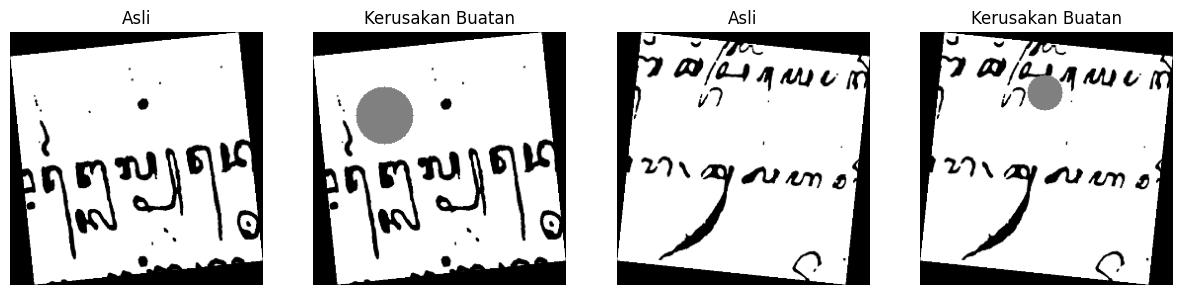

In [15]:
# Mengecek x_train dan train_data
print(f"x_train shape => {x_train.shape} & train_data shape => {train_data.shape}")

# visualisasi data x_train dan train_data, apakah sama atau tidak
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(x_train[0])
axes[0].set_title("Asli")
axes[0].axis('off')

axes[1].imshow(train_data[0])
axes[1].set_title("Kerusakan Buatan")
axes[1].axis('off')

axes[2].imshow(x_train[5])
axes[2].set_title("Asli")
axes[2].axis('off')

axes[3].imshow(train_data[5])
axes[3].set_title("Kerusakan Buatan")
axes[3].axis('off')

plt.show()

## Save .npz (sample)

In [16]:
np.savez('data-bin/train_samples.npz', train_images=train_data, train_labels=train_labels)
np.savez('data-bin/test_samples.npz', test_images=test_data, test_labels=test_labels)

np.savez('data-bin/ori_train.npz', ori_train=x_train)